In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from python.utils import project_path
from python.building_elec_model import building_types_dict

## Load 'quantile mapping'

The following can be used to calculate seasonal quantiles of simulated NYISO load using the ACORN method (baseline + ResStock + ComStock). This could be used to calibrate GenX peak load under different scenarios and realiability thresholds, similar to how traditional capacity planning is done.

In [34]:
def get_load_quantiles(
    q,
    climate_scenario_years,
    resstock_scale_factor,
    comstock_scale_factor,
    years_subset=None,
    resstock_upgrade=1,
    comstock_upgrade=31,
):
    """
    Calculate seasonal load quantiles by combining baseline, ResStock and ComStock load data.

    Parameters
    ----------
    q : float or array-like
        Quantile or sequence of quantiles to compute, must be between 0 and 1
    climate_scenario_years : str
        Climate scenario years identifier used in file paths
    resstock_factor : float
        Scaling factor to apply to ResStock load data
    comstock_factor : float 
        Scaling factor to apply to ComStock load data
    years_subset : list, optional
        List of years to subset the data to
    resstock_upgrade : int, default 1
        ResStock upgrade scenario number
    comstock_upgrade : int, default 31
        ComStock upgrade scenario number

    Returns
    -------
    pd.Series
        Seasonal load quantiles with index ['DJF', 'MAM', 'JJA', 'SON']
        representing Winter, Spring, Summer and Fall respectively
    """
    # Read baseline
    df_baseline = pd.read_parquet(f"{project_path}/data/load/baseline/simulated/load_model_tgw_multizone_NN_{climate_scenario_years}.parquet")
    df_baseline = df_baseline.groupby(['bus_id', 'datetime'])[['load_MW']].sum(numeric_only=True)

    # Read ResStock
    df_resstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/resstock/simulated/bus_level/{climate_scenario_years}_{resstock_upgrade}_{home_type}.parquet") for home_type in building_types_dict['resstock']])
    df_resstock = df_resstock.reset_index()
    df_resstock = df_resstock.groupby(['bus_id','time']).sum()
    df_resstock.index.names = ['bus_id', 'datetime']

    # Read ComStock
    df_comstock = pd.concat([pd.read_parquet(f"{project_path}/data/load/comstock/simulated/bus_level/{climate_scenario_years}_{comstock_upgrade}_{home_type}.parquet") for home_type in building_types_dict['comstock']])
    df_comstock = df_comstock.reset_index()
    df_comstock = df_comstock.groupby(['bus_id','time']).sum()
    df_comstock.index.names = ['bus_id', 'datetime']

    # Combine
    df_load = pd.concat([df_comstock.rename(columns={'bus_load_MW':'load_MW'}) * resstock_scale_factor,
                         df_resstock.rename(columns={'bus_load_MW':'load_MW'}) * resstock_scale_factor,
                         df_baseline]).groupby(['bus_id', 'datetime']).sum().reset_index()

    # Reset indexes
    df_load['date'] = df_load['datetime'].dt.date
    df_load['year'] = df_load['datetime'].dt.year
    df_load['season'] = df_load['datetime'].dt.month % 12 // 3

    # Subset years if desired
    if years_subset is not None:
        df_load = df_load[df_load['year'].isin(years_subset)]

    # Return quantiles
    return df_load.groupby('season')['load_MW'].quantile(q).rename({0:'DJF', 1:'MAM', 2:'JJA', 3:'SON'})

In [37]:
# Example
climate_scenario_years = 'historical_1980_2019'
resstock_scale_factor = 0.5
comstock_scale_factor = 0.5
q = 0.99

get_load_quantiles(q, climate_scenario_years, resstock_scale_factor, comstock_scale_factor)

season
DJF    4062.188638
MAM    3359.399413
JJA    4209.708700
SON    3573.177837
Name: load_MW, dtype: float64

## Load shedding analysis

In [113]:
# Preprocessing function
def _preprocess_outputs(df, name='loadshed_MW'):
    df_agg = pd.DataFrame(df.sum(axis=0)).iloc[2:].rename(columns={0: name})
    df_agg.index = pd.to_datetime(df_agg.index)
    return df_agg.astype(np.float64)

In [106]:
# Load shedding
run_name = "mod_RE_mod_elec_iter0"
climate_scenario_years = "historical_1980_2019"
years = np.arange(1982, 2019 + 1)
acorn_name = "nyiso_only"

output_folder = f"{project_path}/runs/{run_name}/outputs/{climate_scenario_years}/{acorn_name}"

df_loadshed = pd.concat([_preprocess_outputs(pd.read_csv(f"{output_folder}/load_shedding_{year}.csv")) for year in years])

In [107]:
# Create load shedding matrix
df_loadshed.reset_index(inplace=True, names='datetime')

df_loadshed['year'] = df_loadshed['datetime'].dt.year
df_loadshed['month'] = df_loadshed['datetime'].dt.month
df_loadshed['week'] = df_loadshed['datetime'].dt.isocalendar().week

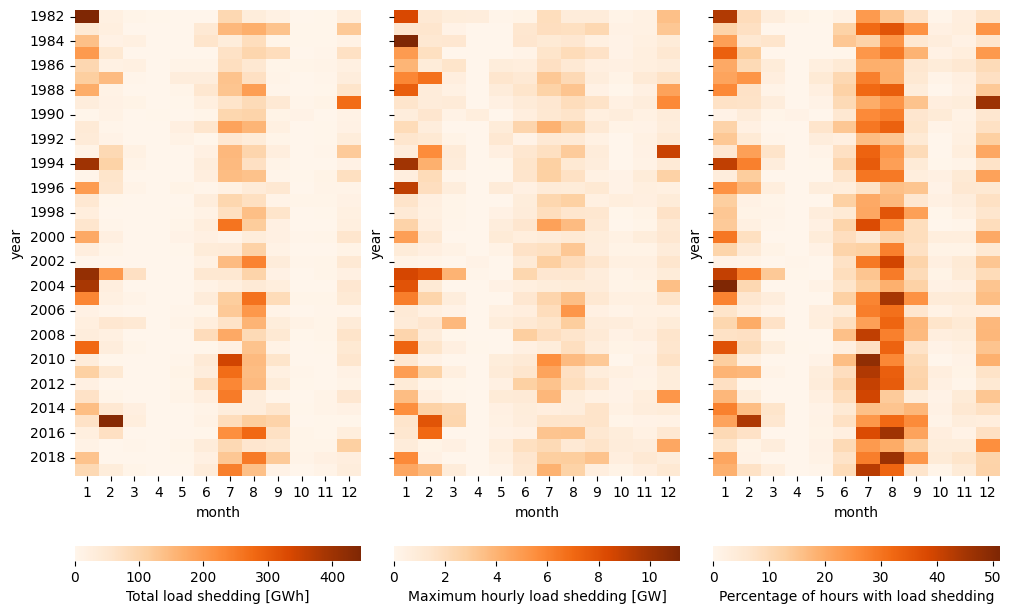

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(10,6), sharey=True, layout='constrained')

# Total across the month
ax = axs[0]

df_loadshed_sum = (
    df_loadshed.groupby(['year', 'month'])[['loadshed_MW']]
    .sum().reset_index()
    .pivot(index='year', columns='month', values='loadshed_MW')
)

sns.heatmap(df_loadshed_sum/1000, annot=False, cmap='Oranges', ax=ax, 
            cbar_kws={'label':'Total load shedding [GWh]', 'location':'bottom'})

# Max across the month
ax = axs[1]

df_loadshed_max = (
    df_loadshed.groupby(['year', 'month'])[['loadshed_MW']]
    .max().reset_index()
    .pivot(index='year', columns='month', values='loadshed_MW')
)

sns.heatmap(df_loadshed_max/1000, annot=False, cmap='Oranges', ax=ax, 
            cbar_kws={'label':'Maximum hourly load shedding [GW]', 'location':'bottom'})

# Fraction of hours
ax = axs[2]

df_loadshed_frac = (
    df_loadshed.groupby(['year', 'month'])[['loadshed_MW']].apply(lambda x: (x > 0.).mean())
    .reset_index()
    .pivot(index='year', columns='month', values='loadshed_MW')
)

sns.heatmap(100 * df_loadshed_frac, annot=False, cmap='Oranges', ax=ax, 
            cbar_kws={'label':'Percentage of hours with load shedding', 'location':'bottom'})

plt.savefig(f"{project_path}/runs/{run_name}/figs/{climate_scenario_years}_{acorn_name}_load_shedding_matrix.png", dpi=300, bbox_inches='tight')

In [114]:
# Check if this makes sense
year = 2015
df_gen = _preprocess_outputs(pd.read_csv(f"{output_folder}/gen_{year}.csv"), name='gen_MW')
df_load = _preprocess_outputs(pd.read_csv(f"{output_folder}/residual_load_{year}.csv"), name='load_MW')
df_solar = _preprocess_outputs(pd.read_csv(f"{output_folder}/residual_load_{year}.csv"), name='load_MW')

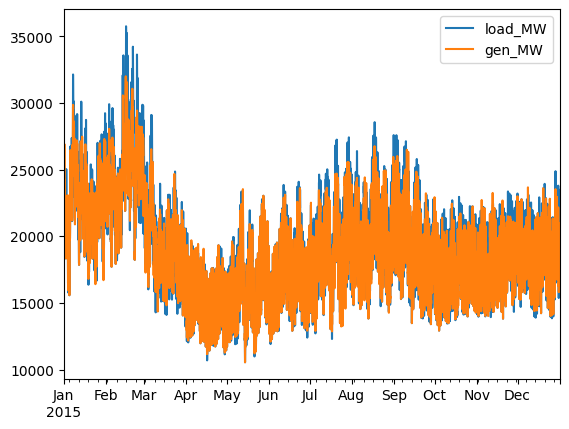

In [125]:
fig, ax = plt.subplots()
df_load.plot(ax=ax)
df_gen.plot(ax=ax)
plt.show()